# Auto-diff with JAX

https://github.com/google/jax

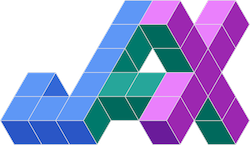

JAX is a Google research project, developed by the former developers of [Autograd](https://github.com/hips/autograd), bringing together the potentialities of Autograd and the linear algebra accelerator [XLA](https://www.tensorflow.org/xla). It is based on three pillars:
- `grad`: Automatic Differentiation
- `jit`: Just-in-time compilation
- `vmap`: Automatic vectorization.

## Automatic differentiation in JAX

JAX augments numpy and Python code with function transformations which make it trivial to perform operations common in machine learning programs. JAX's augmented numpy lives at `jax.numpy`. With a few exceptions, you can think of `jax.numpy` as directly interchangeable with `numpy`. As a general rule, you should use `jax.numpy` whenever you plan to use any of JAX's transformations.

The function `df = jax.grad(f, argnums = 0)` takes the callable object `f` and returns another callable object, `df`, evaluating the gradient of `f` w.r.t. the argument(s) of index(es) `argnums`. For more information, check out the [documentation](https://jax.readthedocs.io/en/latest/jax.html?highlight=grad#jax.grad).

**Example**

We consider the function:
$$
f(x) = x \sin(x^2)
$$

and we compute $f'(x_0)$ for $x_0 = 0.13$

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax

func = lambda x: x * jnp.sin(x**2)
x0 = 0.13
dfunc_AD = jax.grad(func)
df_AD = dfunc_AD(x0)

# analytical derivative
dfunc = lambda x : np.sin(x**2)+2 * x**2 * np.cos(x**2)
df_ex = dfunc(x0)

print('df (ex): %f' % df_ex)
print('df (AD): %f' % df_AD)

print('err (AD): %e' % (abs(df_AD - df_ex)/abs(df_ex)))

df (ex): 0.050694
df (AD): 0.050694
err (AD): 7.348529e-08


# Artificial-Neural-Network gradient computation in JAX

Forget for a wile about JAX. We want to build a fully connected ANN with the architecture shown below (1 input, 1 output, 2 hidden layers with 4 and 3 neurons respectively), with `tanh` as activation function.

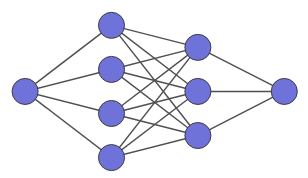

The ANN can be written as
$$
y = ANN(x) = W_3  \tanh( W_2 \tanh (W_1 x - b_1) - b_2) - b_3
$$
First, randomly define the weights and biases.

In [ ]:
params = [
          np.random.randn(4),     # W1
          np.random.randn(4),     # b1
          np.random.randn(3,4),   # W2
          np.random.randn(3),     # b2
          np.random.randn(3),     # W3
          np.random.randn(),      # b3
         ]

Then, define the function `ANN`, and compute `ANN`(1.0).

In [ ]:
def ANN(x, params):
  W1, b1, W2, b2, W3, b3 = params
  hidden1 = np.tanh(np.dot(W1, x) + b1)
  hidden2 = np.tanh(np.dot(W2, hidden1) + b2)
  return np.dot(W3, hidden2) + b3

output = ANN(1.0, params)
print(output)

0.8440173526744559


### Gradients computation

Now, rewrite the function `ANN` using the JAX's augmented `numpy`.
Compute again `ANN`(1.0), and compute the derivative of `ANN` w.r.t. `x` using `jax.grad`. Evaluate the result in `x` = 1.0.

In [ ]:
def ANN(x, params):
  W1, b1, W2, b2, W3, b3 = params
  hidden1 = jnp.tanh(jnp.dot(W1, x) + b1)
  hidden2 = jnp.tanh(jnp.dot(W2, hidden1) + b2)
  return jnp.dot(W3, hidden2) + b3

x0 = 1.0
output = ANN(x0, params)
print(output)

dANN_dx = jax.grad(ANN)
print(dANN_dx(x0, params))


0.84401745
-3.4828024


Plot the graph of the function `ANN` and of its first derivative in the interval $x \in [-10, 10]$.

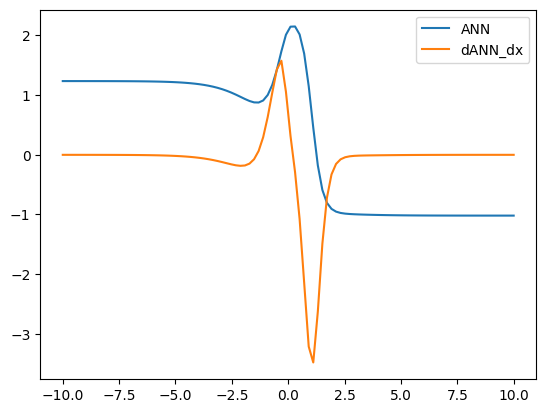

In [ ]:
import matplotlib.pyplot as plt

xx = np.linspace(-10, 10, 100)
yy = [ANN(x, params) for x in xx]
zz = [dANN_dx(x, params) for x in xx]

plt.plot(xx, yy, label = 'ANN')
plt.plot(xx, zz, label = 'dANN_dx')
plt.legend()

Compute the gradient of `ANN` w.r.t. the neural network parameters.

In [ ]:
dANN_dp = jax.grad(ANN, argnums=1)
dANN_dp(x0, params)

[Array([ 4.3989363 , -1.1326336 ,  0.10531151,  0.01234601], dtype=float32),
 Array([ 4.3989363 , -1.1326336 ,  0.10531151,  0.01234601], dtype=float32),
 Array([[-1.2671050e-03, -2.7352453e-03, -4.1983267e-03,  4.3595294e-03],
        [ 2.1889146e-01,  4.7251159e-01,  7.2525787e-01, -7.5310552e-01],
        [ 5.1303548e-01,  1.1074677e+00,  1.6998518e+00, -1.7651207e+00]],      dtype=float32),
 Array([-0.004426  ,  0.76458883,  1.7920352 ], dtype=float32),
 Array([-9.9752688e-01,  2.2666408e-01,  8.9281762e-04], dtype=float32),
 Array(1., dtype=float32, weak_type=True)]

Evaluate the execution times of the function `ANN` and of the functions computing gradients by the magic command `%timeit`

In [ ]:
%timeit ANN(x0, params)

90.6 µs ± 20 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit dANN_dx(x0, params)

11.8 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit dANN_dp(x0, params)

13.6 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Speed it up with JIT!

Compile the function `ANN` and the functions that compute its gradients using the [just-in-time compilation](https://en.wikipedia.org/wiki/Just-in-time_compilation) utility `jax.jit`.

With `f_jit = jax.jit(f)` a callable `f` is compiled into `f_jit`.

Then, check that the compiled `ANN` function returns the same results as the original one. Finally, evaluate the execution times and compare it with the previous results.

In [ ]:
ANN_jit = jax.jit(ANN)
dANN_dx_jit = jax.jit(dANN_dx)
dANN_dp_jit = jax.jit(dANN_dp)

print(ANN(x0, params))
print(ANN_jit(x0, params))

0.84401745
0.8440175


In [ ]:
%timeit ANN_jit(x0, params)

22.6 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit dANN_dx_jit(x0, params)

35.3 µs ± 6.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit dANN_dp_jit(x0, params)

37.7 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
